# Fine-tuning VGG19

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 03:10:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c1d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   159MB/s    in 0.4s    

2019-04-18 03:10:42 (159 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile
from google.colab import files

from keras.applications import VGG19
from keras import layers
from keras import models
from keras import optimizers
from keras.regularizers import l1
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

import numpy as np

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Using TensorFlow backend.


In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Load the convolutional base and freeze it

In [4]:
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


## Create model to put on top of VGG19

This model contains densely connected layers that will use the features extracted from the convolutional base to classify images as either cats or dogs.  Because these models suffer greatly from overfitting, we use a high drop out rate for the dense layer, as well decreasing the size of the dense layer in order to reduce the complexity of the model and further fight overfitting.  Also added is L1-Regularization, which helps against overfitting by emphasizing features that are important in classification and penalizing those that are not.

In [5]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [7]:
# Use batches of powers of two to take advantage of GPU.
batches = 32
val_steps = int(1000/batches)
train_steps = int(2000/batches)

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


# Compile model with Adam as optimizer.
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=1e-5), 
    metrics=['acc'])

# Training phase
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=val_steps
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
62/62 [==============================] - 22s 363ms/step - loss: 138.4566 - acc: 0.4561 - val_loss: 135.3027 - val_acc: 0.5081
Epoch 2/40
62/62 [==============================] - 17s 271ms/step - loss: 132.3346 - acc: 0.5126 - val_loss: 129.2749 - val_acc: 0.5258
Epoch 3/40
62/62 [==============================] - 16s 250ms/step - loss: 126.3830 - acc: 0.4904 - val_loss: 123.3769 - val_acc: 0.5393
Epoch 4/40
62/62 [==============================] - 16s 256ms/step - loss: 120.5445 - acc: 0.5227 - val_loss: 117.5914 - val_acc: 0.6064
Epoch 5/40
62/62 [==============================] - 16s 257ms/step - loss: 114.8423 - acc: 0.5378 - val_loss: 111.9725 - val_acc: 0.6033
Epoch 6/40
62/62 [==============================] - 17s 277ms/step - loss: 109.2915 - acc: 0.5388 - val_loss: 106.4789 - val_acc: 0.6302
Epoch 7/40
62/62 [============================

## Display curves of loss and accuracy during training

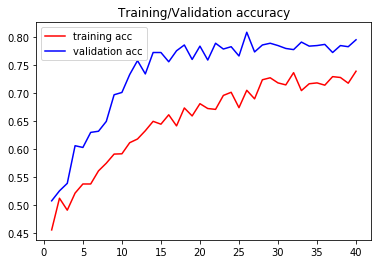

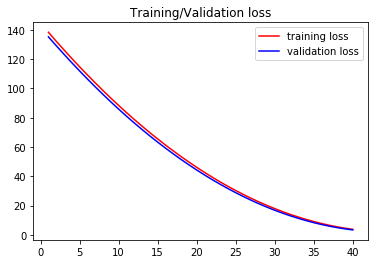

In [8]:
def plot_graphs(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  # training and validation accuracy

  plt.plot(epochs, acc, 'r', label='training acc')
  plt.plot(epochs, val_acc, 'b', label='validation acc')
  plt.title('Training/Validation accuracy')
  plt.legend()

  plt.figure()

  # training and validation loss

  plt.plot(epochs, loss, 'r', label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.title('Training/Validation loss')
  plt.legend()

  plt.show()

plot_graphs(history)

While there appears to be underfitting, this is because of the L1-regularization and the dropout, and in reality both training and validation are steadily improving, as seen by the smooth decrease in the loss.  The real improvement will be seen as we begin fine-tuning.

## Fine-tuning

In addition to fine-tuning the model, where one convolutional block in the model is unfrozen, we also apply a learning rate schedule.  This way, the hope is that we can squeeze out as much accuracy as possible from the model.

In [0]:
# Unfreeze all layers in block 5 of VGG19.

conv_base.trainable = True
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    layer.trainable = True

In [0]:
# Establish the schedule for learning rate decrease.
def lr_schedule(epoch):
  
  lr = 1e-5
  
  if epoch > 75:
      lr *= 1e-3
  elif epoch > 50:
      lr *= 1e-2
  elif epoch > 25:
      lr *= 1e-1
  return lr

In [11]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=lr_schedule(0)), 
    metrics=['acc'])

model_type = "VGG19"
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')

# Every time the model has a better validation accuracy than before, update the saved model.
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate scheduling.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# Create the learning rate scheuler and reducer to monitor the model.
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-8)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the model.
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps,
    workers=4,
    callbacks=callbacks)

Epoch 1/100
62/62 [==============================] - 30s 491ms/step - loss: 2.8970 - acc: 0.8241 - val_loss: 2.4514 - val_acc: 0.9122

Epoch 00001: val_acc improved from -inf to 0.91219, saving model to /content/saved_models/cifar10_VGG19_model.001.h5
Epoch 2/100
62/62 [==============================] - 22s 347ms/step - loss: 2.3098 - acc: 0.8770 - val_loss: 2.0015 - val_acc: 0.9256

Epoch 00002: val_acc improved from 0.91219 to 0.92562, saving model to /content/saved_models/cifar10_VGG19_model.002.h5
Epoch 3/100
62/62 [==============================] - 21s 344ms/step - loss: 1.9137 - acc: 0.9032 - val_loss: 1.7391 - val_acc: 0.9246

Epoch 00003: val_acc did not improve from 0.92562
Epoch 4/100
62/62 [==============================] - 21s 345ms/step - loss: 1.6702 - acc: 0.9194 - val_loss: 1.5432 - val_acc: 0.9442

Epoch 00004: val_acc improved from 0.92562 to 0.94421, saving model to /content/saved_models/cifar10_VGG19_model.004.h5
Epoch 5/100
62/62 [==============================] - 

## Display Fine-Tuning Train/Validation Accuracy/Loss Graphs

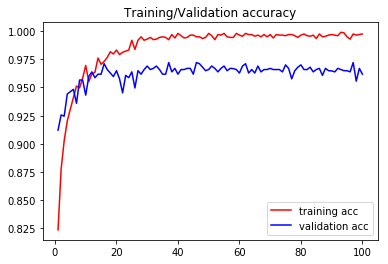

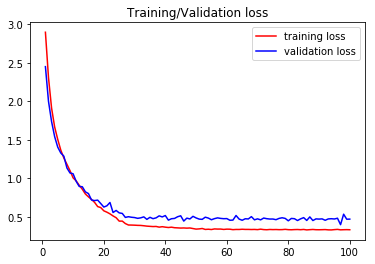

In [12]:
plot_graphs(history)

In [13]:
!ls /content/saved_models/ | tail -1

cifar10_VGG19_model.037.h5


In [0]:
cp /content/saved_models/cifar10_VGG19_model.037.h5 /content/VGG19_P2_best.h5

## Print out Evaluation Validation Loss/Accuracy

In [0]:
from keras.models import load_model

model = load_model('VGG19_P2_best.h5')
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=val_steps)

In [20]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.4800101905322272
Validation accuracy: 0.9710743801652892


## Save the best model

Because of how huge this model turns out to be (over 241 M), collab appears to not be able to handle downloading it through command, so it has to be downloaded manually once it is saved.  The file can be fetched from Github, though, and as long as LFS is installed on the command line, can also be pushed to Github.

In [0]:
model_name = 'VGG19_P2_best.h5'
with open(model_name, 'r') as f:
  files.download(model_name)